In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LassoCV
from time import time
import warnings
warnings.filterwarnings('ignore')

In [8]:
# dfGb= pd.read_csv("../../our_data/Etap3/dfGB_merged.csv")

# dfUS = pd.read_csv("../../our_data/Etap3/dfUS_merged.csv")

dfGb= pd.read_csv("../../our_data/Etap3/GB_final.csv")

dfUS = pd.read_csv("../../our_data/Etap3/US_final.csv")

In [9]:
dfGb.shape

(3235, 138)

In [63]:
US_cats

{'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '29': 'Nonprofits & Activism',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

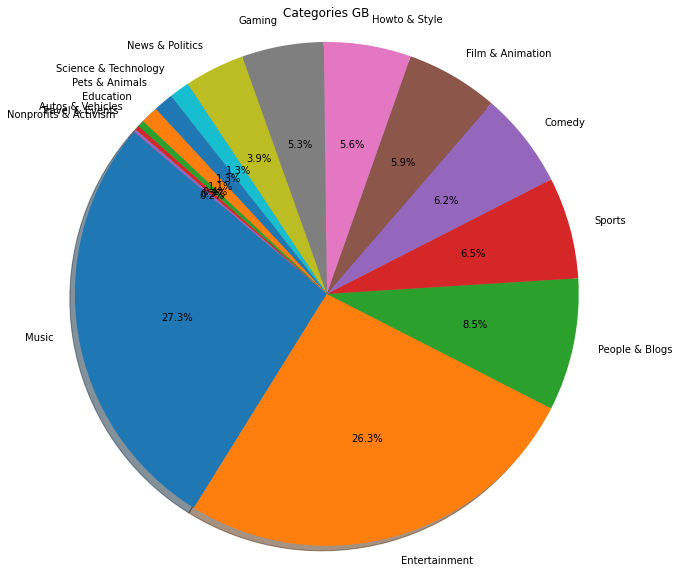

In [52]:
with open("./../../data/youtube_data/US_category_id.json") as file:
    data = json.loads(file.read())
    
US_cats = {}
for item in data['items']:
    US_cats[item['id']] = item['snippet']['title']



gbCtr = Counter(dfGb.loc[:, "category_id"]).most_common()
gbCatdata = []
gbCatlabels = []
for c in gbCtr:
    try:
        gbCatlabels.append(US_cats[str(int(c[0]))])
        gbCatdata.append(c[1])
    except:
        print("error")


plt.figure(figsize=(10,10))
plt.pie(gbCatdata, labels=gbCatlabels ,autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Categories GB")
plt.axis('equal')
plt.show()


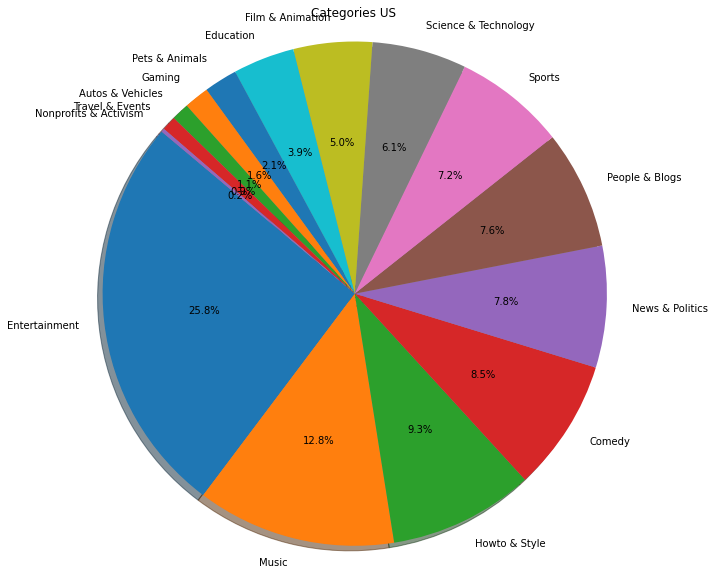

In [53]:
usCtr = Counter(dfUS.loc[:, "category_id"]).most_common()
usCatdata = []
usCatlabels = []
for c in usCtr:
    try:
        usCatlabels.append(US_cats[str(int(c[0]))])

        usCatdata.append(c[1])
    except:
         print("error")

# Plot
plt.figure(figsize=(10,10
                    
plt.pie(usCatdata, labels=usCatlabels ,autopct='%1.1f%%', shadow=True, startangle=140)
                    
plt.title("Categories US")

plt.axis('equal')
plt.show()


## Spearman correlation between atributes

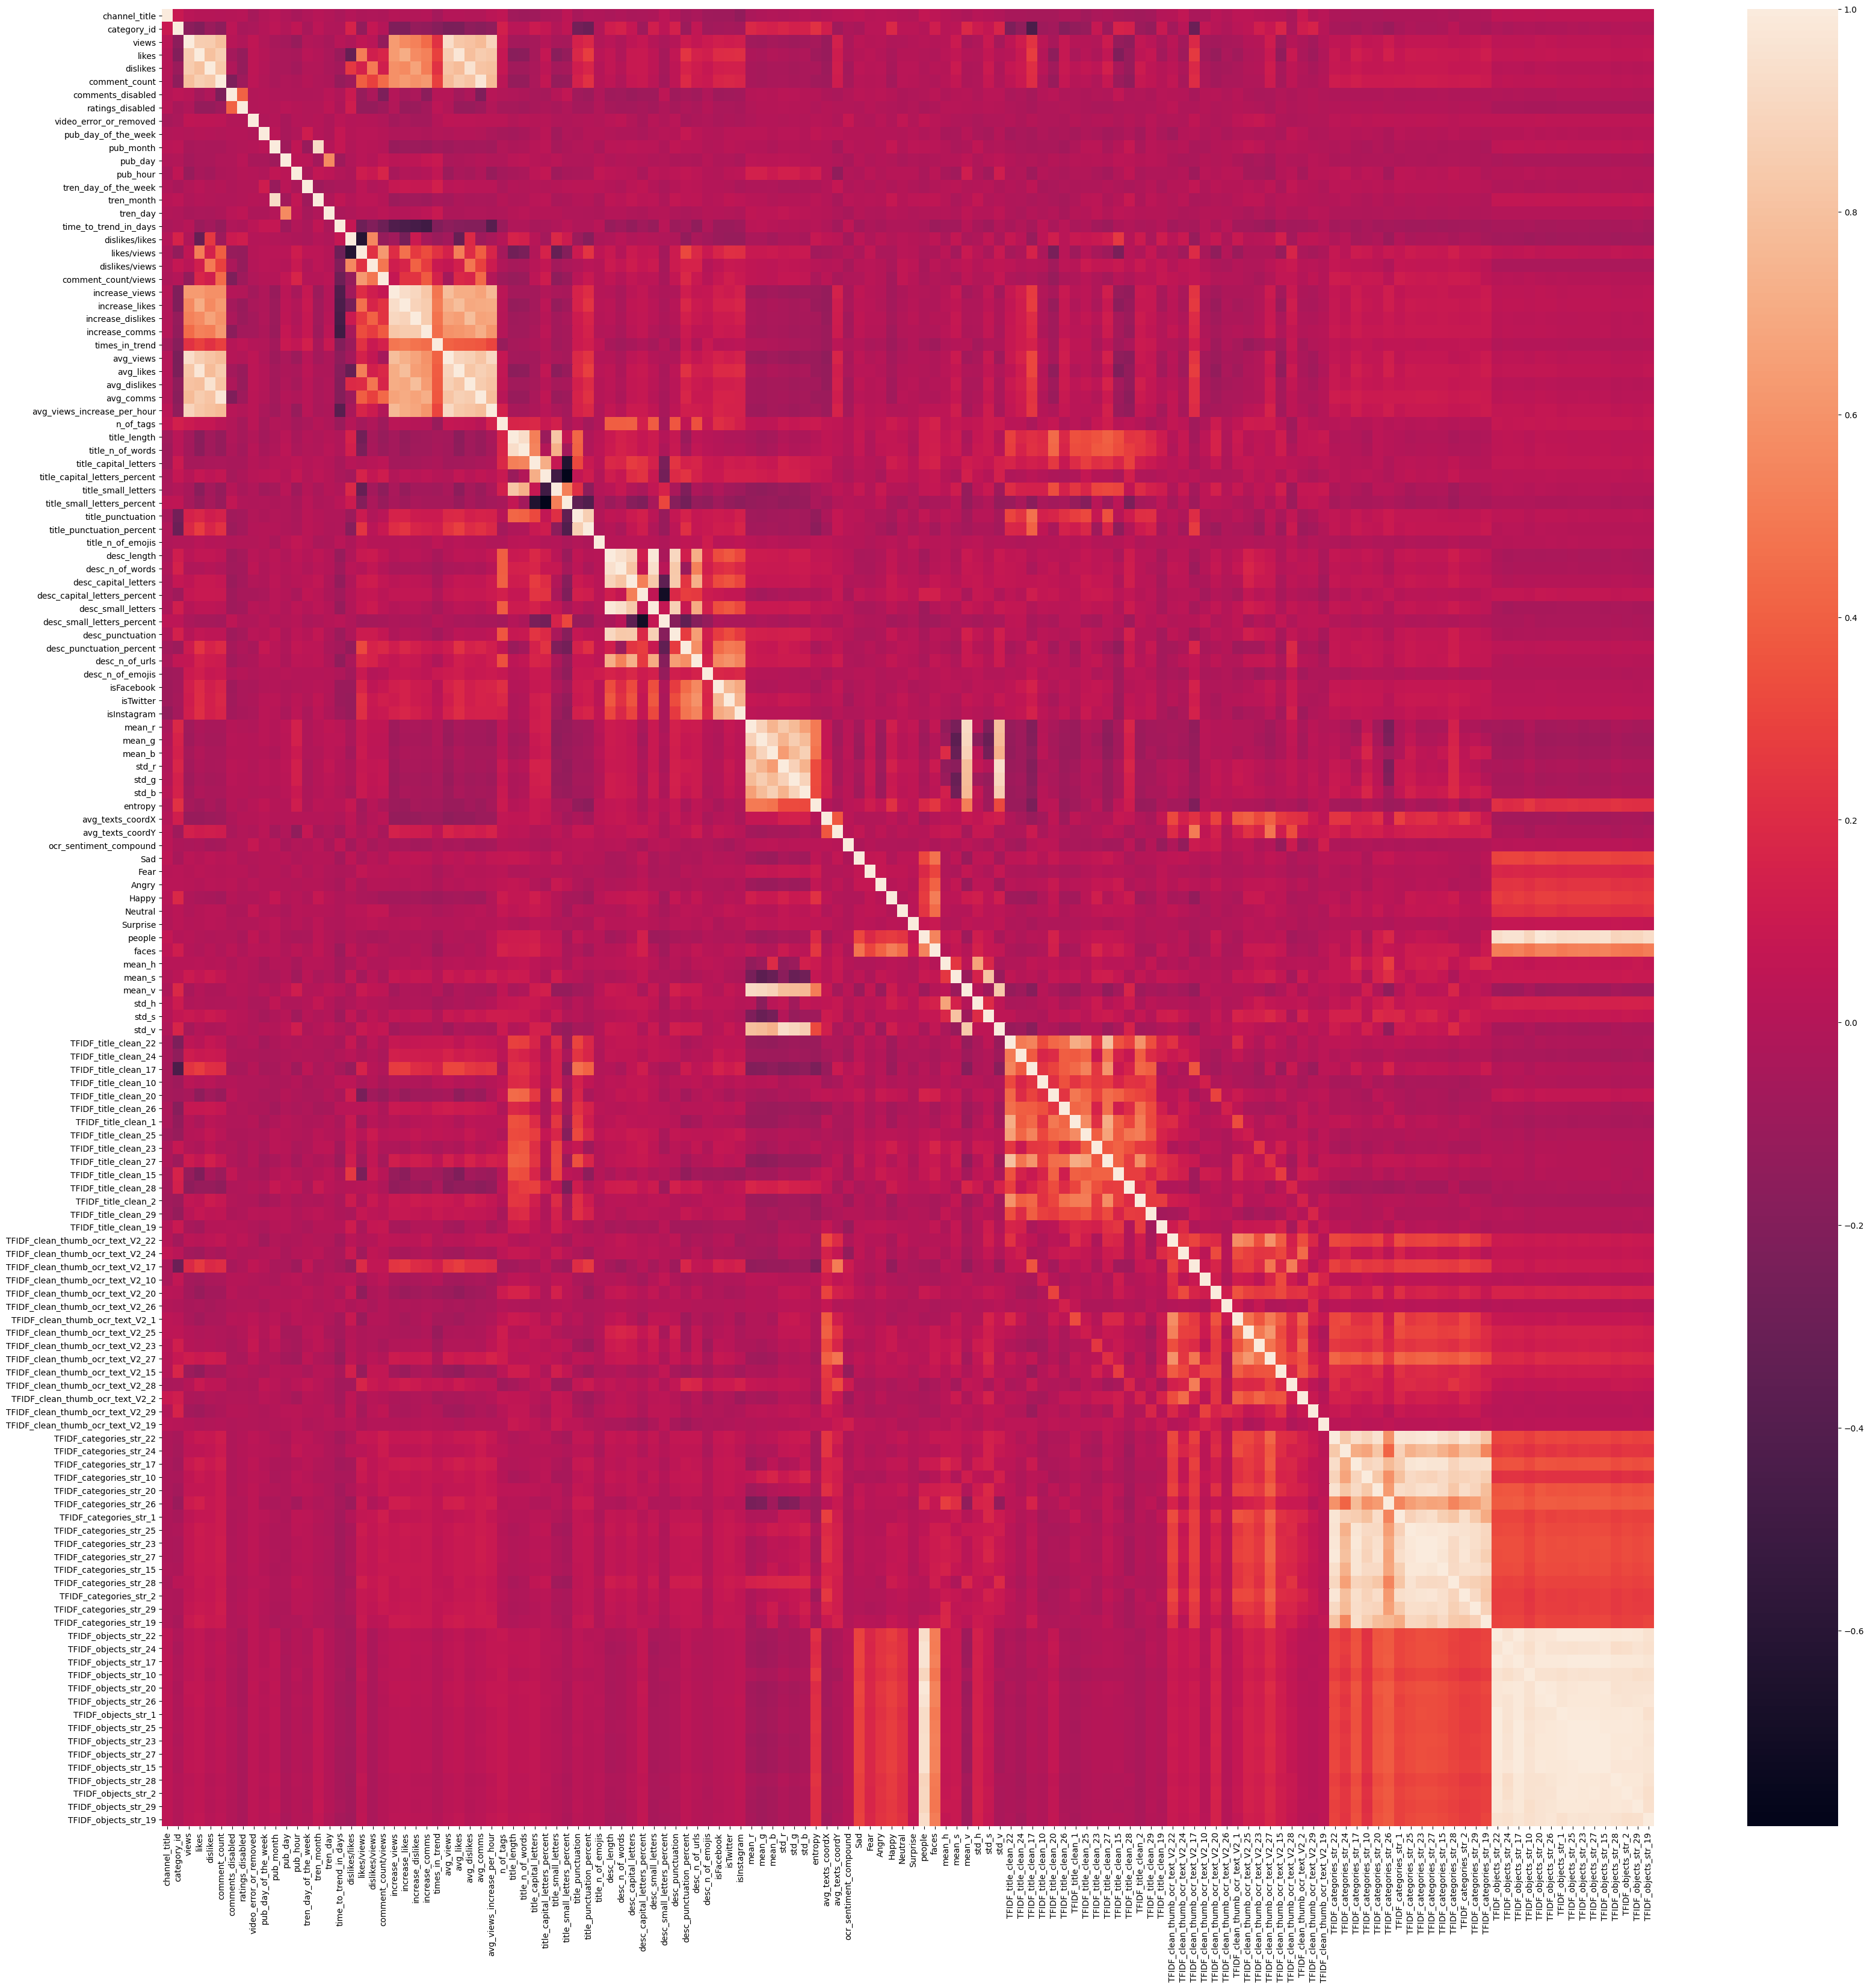

In [10]:
corr = dfGb.corr(method='spearman')
plt.figure(figsize=(40,40),dpi=100)
sns.heatmap(corr)
plt.savefig("../../our_data/Etap3/corr_spearmanGB.pdf")
plt.show()

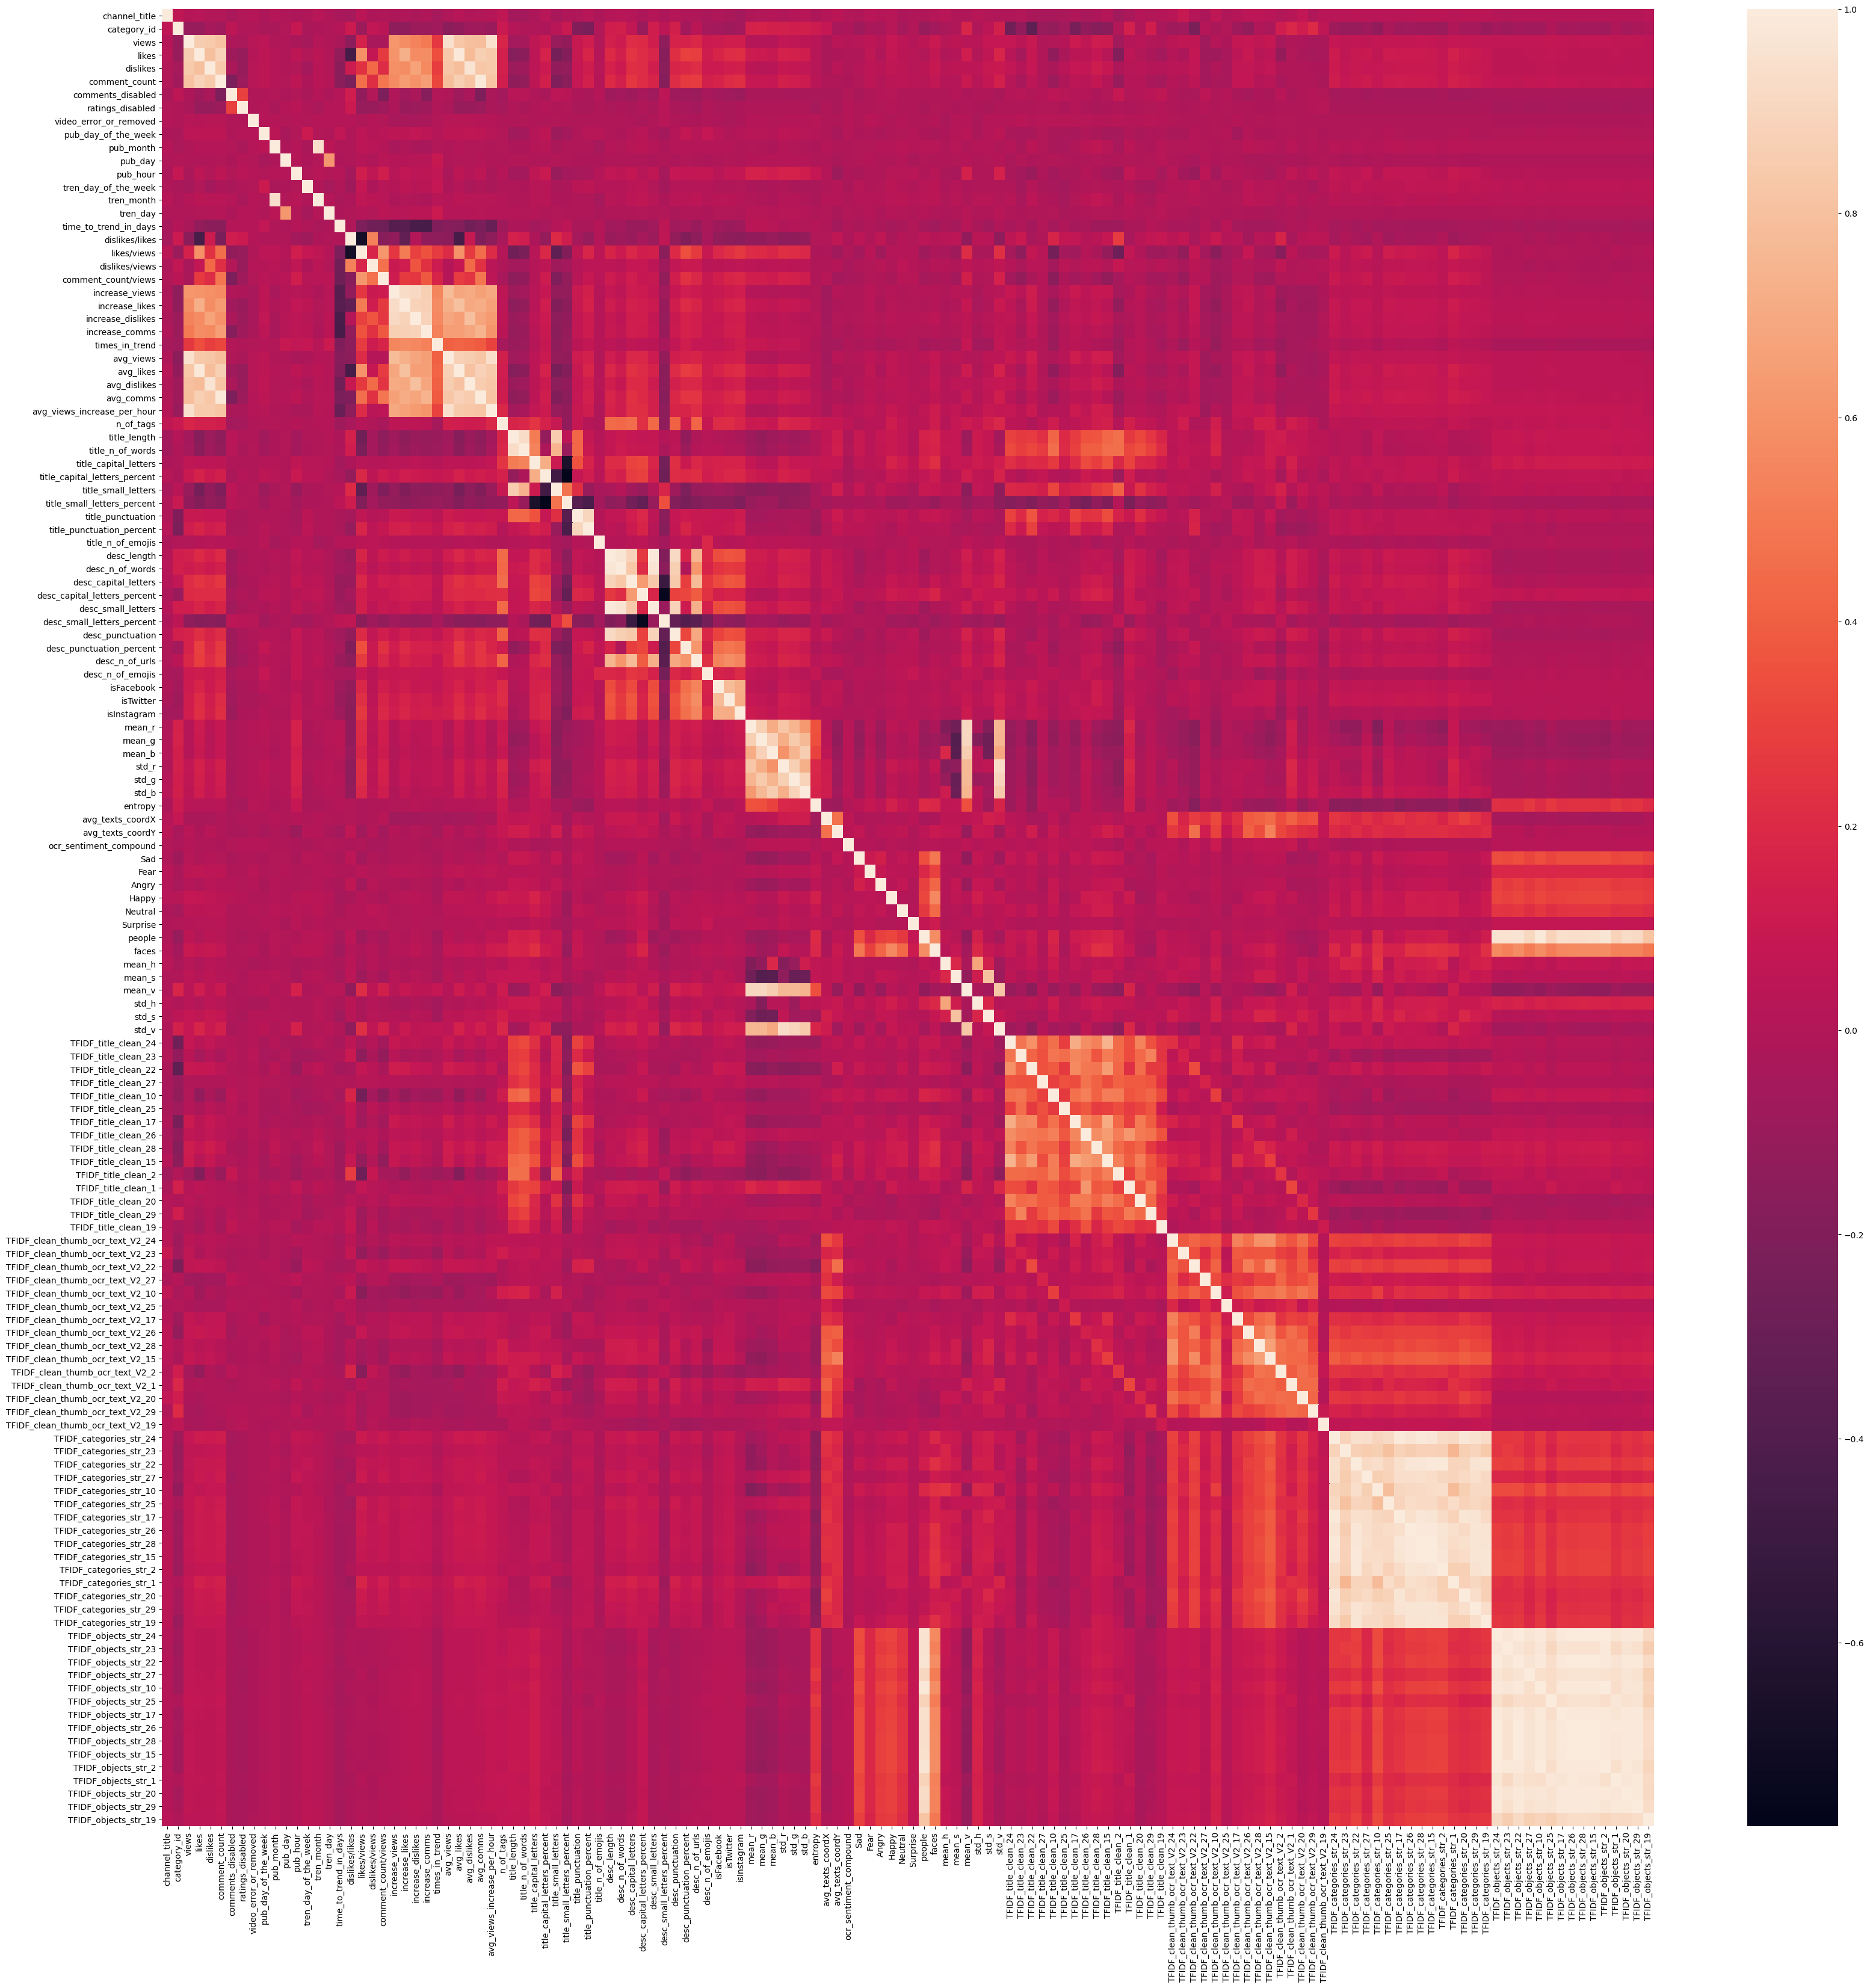

In [11]:
corr = dfUS.corr(method='spearman')
plt.figure(figsize=(40,40),dpi=100)
sns.heatmap(corr)
plt.savefig("../../our_data/Etap3/corr_spearmanUS.pdf")
plt.show()

In [60]:
pd.set_option('display.max_columns', None)

def prepeareData(df):
    
    min_max_scaler = preprocessing.MinMaxScaler()

    df = df[ df['category_id'].notna() ]
    y = df.loc[:,'category_id']
    X  = df.loc[:, df.columns != 'category_id']
    X = X.select_dtypes(include=np.number)
    X = X.fillna(-1)
    return X, y


def getFI_RForest(X,y,printF= True,plot = True):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    df = pd.DataFrame(np.dstack([importances,X.columns])[0])
    if plot:    
        plt.figure(figsize=(10,10))

        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), importances[indices],
                color="r", yerr=std[indices], align="center")
#         plt.bar(range(X.shape[1]), x=np.arange(0,len(df)),
#                 color="r", yerr=std[indices], align="center")
#         plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    if printF: 
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

    
    return df.sort_values(by=0,ascending=False)

def getFI_Bagging(X,y,printF= True,plot = True):
    clf = BaggingClassifier(DecisionTreeClassifier())
    clf.fit(X, y)

    feature_importances = np.mean([
        tree.feature_importances_ for tree in clf.estimators_
    ], axis=0)

    df = pd.DataFrame(np.dstack([feature_importances,X.columns])[0])
    
    indices = np.argsort(feature_importances)[::-1]

    if plot:
        
        plt.figure(figsize=(10,10))
            
        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), feature_importances[indices],
                color="r",  align="center")
#         plt.bar(range(X.shape[1]),
#                 color="r",  align="center")
#         plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    if printF: 
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], feature_importances[indices[f]]))
            
    return df.sort_values(by=0,ascending=False)

def selectFromModelSVC(X,y,printF= True,plot = True):
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    feature_idx = model.get_support()
    feature_name = X.columns[feature_idx]    
    if printF:
        print("Before: "+ str(X.shape))
        print("After: "+ str(X_new.shape))        
        print(feature_name)
    return feature_name
def getFILasso(X,y,printF= True,plot = True):
    lasso = LassoCV().fit(X, y)
    importance = np.abs(lasso.coef_)
    feature_names = np.array(X.columns)

    df = pd.DataFrame(np.dstack([importance,X.columns])[0])
    df = df.sort_values(by=0,ascending=False)
    if plot:
        plt.figure(figsize=(10,10))

        plt.bar(height=df[0], x=np.arange(0,len(df)))
        plt.title("Feature importances via coefficients")
        plt.show()
    if printF:
        pd.set_option('display.max_rows', None)        
        print(df.sort_values(by=0,ascending=False))
        pd.set_option('display.max_rows', 20)        

    return df.sort_values(by=0,ascending=False)
    
    


# US data feature importance

In [61]:
X, y = prepeareData(dfUS)
print(dfUS.shape)
dfUS

(6283, 138)


,channel_title,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,pub_day_of_the_week,pub_month,pub_day,pub_hour,tren_day_of_the_week,tren_month,tren_day,time_to_trend_in_days,dislikes/likes,likes/views,dislikes/views,comment_count/views,increase_views,increase_likes,increase_dislikes,increase_comms,times_in_trend,avg_views,avg_likes,avg_dislikes,avg_comms,avg_views_increase_per_hour,n_of_tags,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram,mean_r,mean_g,mean_b,std_r,std_g,std_b,entropy,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,Sad,Fear,Angry,Happy,Neutral,Surprise,people,faces,mean_h,mean_s,mean_v,std_h,std_s,std_v,TFIDF_title_clean_24,TFIDF_title_clean_23,TFIDF_title_clean_22,TFIDF_title_clean_27,TFIDF_title_clean_10,TFIDF_title_clean_25,TFIDF_title_clean_17,TFIDF_title_clean_26,TFIDF_title_clean_28,TFIDF_title_clean_15,TFIDF_title_clean_2,TFIDF_title_clean_1,TFIDF_title_clean_20,TFIDF_title_clean_29,TFIDF_title_clean_19,TFIDF_clean_thumb_ocr_text_V2_24,TFIDF_clean_thumb_ocr_text_V2_23,TFIDF_clean_thumb_ocr_text_V2_22,TFIDF_clean_thumb_ocr_text_V2_27,TFIDF_clean_thumb_ocr_text_V2_10,TFIDF_clean_thumb_ocr_text_V2_25,TFIDF_clean_thumb_ocr_text_V2_17,TFIDF_clean_thumb_ocr_text_V2_26,TFIDF_clean_thumb_ocr_text_V2_28,TFIDF_clean_thumb_ocr_text_V2_15,TFIDF_clean_thumb_ocr_text_V2_2,TFIDF_clean_thumb_ocr_text_V2_1,TFIDF_clean_thumb_ocr_text_V2_20,TFIDF_clean_thumb_ocr_text_V2_29,TFIDF_clean_thumb_ocr_text_V2_19,TFIDF_categories_str_24,TFIDF_categories_str_23,TFIDF_categories_str_22,TFIDF_categories_str_27,TFIDF_categories_str_10,TFIDF_categories_str_25,TFIDF_categories_str_17,TFIDF_categories_str_26,TFIDF_categories_str_28,TFIDF_categories_str_15,TFIDF_categories_str_2,TFIDF_categories_str_1,TFIDF_categories_str_20,TFIDF_categories_str_29,TFIDF_categories_str_19,TFIDF_objects_str_24,TFIDF_objects_str_23,TFIDF_objects_str_22,TFIDF_objects_str_27,TFIDF_objects_str_10,TFIDF_objects_str_25,TFIDF_objects_str_17,TFIDF_objects_str_26,TFIDF_objects_str_28,TFIDF_objects_str_15,TFIDF_objects_str_2,TFIDF_objects_str_1,TFIDF_objects_str_20,TFIDF_objects_str_29,TFIDF_objects_str_19
0,1788,24.0,475965.0,6531.0,172.0,271.0,0,0,0,0.0,6.0,4.0,13.0,2.0,6.0,6.0,2.458322,0.026336,0.013722,0.000361,0.000569,129541.0,1317.0,60.0,83.0,6.0,6.891170e+05,8699.500000,274.333333,369.166667,1.936138e+05,33.0,74.0,11.0,9.0,0.121622,53.0,0.716216,2.0,0.027027,0.0,101.0,18.0,4.0,0.039604,76.0,0.752475,3.0,0.029703,0.0,0.0,0,0,0,90.574479,93.971152,100.170700,86.675586,79.247903,84.228609,6.863646,-1.000000,-1.0,0.0000,1.0,0.0,1.0,0.0,0.0,0.0,5.0,2.0,0.237775,0.307926,0.451148,0.279769,0.328648,0.354018,0.014316,0.000000,0.025896,0.022466,0.102454,0.000000,0.000000,0.123249,0.061078,0.129025,0.089916,0.059791,0.013277,0.037494,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.041714,0.016043,0.053772,0.000000,0.006021,0.240422,0.024563,0.098767,0.049464,0.192141,0.071065,0.111225,0.017786,0.112521,0.000000,6.431105,4.334455,6.893581,4.964066,5.507132,5.021348,7.325898,6.876699,7.109882,8.471034,5.963728,8.601672,6.810041,6.250993,2.560712
1,1788,24.0,563746.0,4429.0,54.0,94.0,0,0,0,0.0,1.0,29.0,14.0,3.0,2.0,1.0,3.416204,0.012192,0.007856,0.000096,0.000167,0.0,0.0,0.0,0.0,1.0,5.637460e+05,4429.000000,54.000000,94.000000,1.650212e+05,33.0,75.0,10.0,8.0,0.106667,56.0,0.746667,2.0,0.026667,0.0,244.0,41.0,11.0,0.045082,186.0,0.762295,7.0,0.028689,0.0,0.0,0,0,0,97.887002,102.937506,109.637251,94.442658,86.405121,91.054313,6.788487,-1.000000,-1.0,0.0000,1.0,1.0,1.0,0.

## Feature Importance based on Random Forest

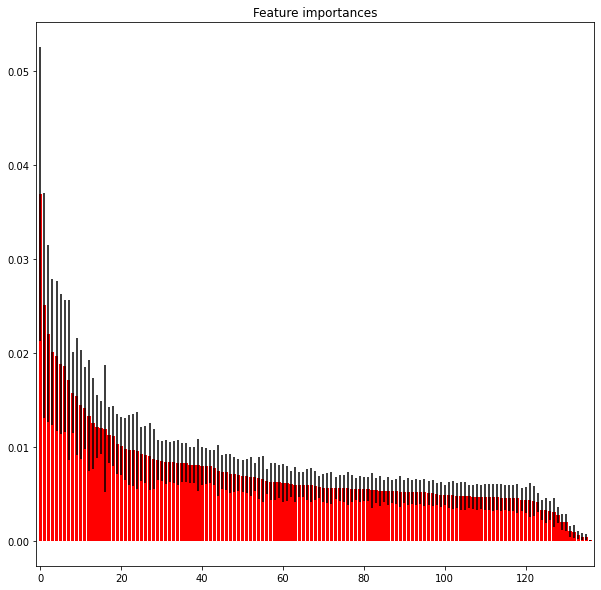

Feature ranking:
1. feature TFIDF_clean_thumb_ocr_text_V2_22 (0.036853)
2. feature TFIDF_title_clean_22 (0.025015)
3. feature TFIDF_title_clean_10 (0.022016)
4. feature TFIDF_title_clean_15 (0.020061)
5. feature TFIDF_clean_thumb_ocr_text_V2_15 (0.019608)
6. feature TFIDF_title_clean_1 (0.018807)
7. feature TFIDF_title_clean_2 (0.018587)
8. feature TFIDF_clean_thumb_ocr_text_V2_2 (0.017054)
9. feature TFIDF_title_clean_29 (0.015724)
10. feature likes/views (0.015337)
11. feature TFIDF_title_clean_24 (0.014451)
12. feature TFIDF_title_clean_28 (0.014079)
13. feature TFIDF_clean_thumb_ocr_text_V2_1 (0.013277)
14. feature TFIDF_clean_thumb_ocr_text_V2_28 (0.012498)
15. feature channel_title (0.012083)
16. feature TFIDF_title_clean_26 (0.012024)
17. feature TFIDF_clean_thumb_ocr_text_V2_10 (0.011877)
18. feature TFIDF_title_clean_20 (0.011262)
19. feature TFIDF_title_clean_27 (0.011120)
20. feature n_of_tags (0.010275)
21. feature TFIDF_title_clean_17 (0.010095)
22. feature TFIDF_clean_thu

In [62]:
r1 = getFI_RForest(X,y)

## Feature Importance based on Bagging + Decision tree

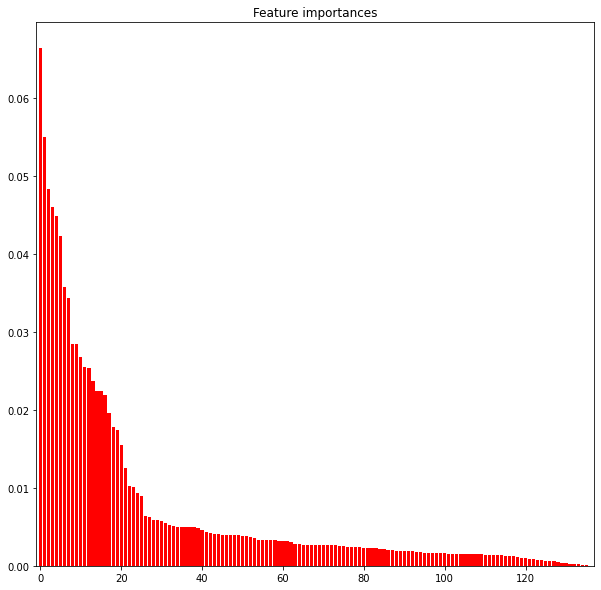

Feature ranking:
1. feature TFIDF_clean_thumb_ocr_text_V2_22 (0.066372)
2. feature TFIDF_clean_thumb_ocr_text_V2_15 (0.054923)
3. feature TFIDF_title_clean_10 (0.048336)
4. feature TFIDF_title_clean_1 (0.046048)
5. feature TFIDF_title_clean_15 (0.044867)
6. feature TFIDF_title_clean_22 (0.042319)
7. feature TFIDF_clean_thumb_ocr_text_V2_28 (0.035804)
8. feature TFIDF_clean_thumb_ocr_text_V2_2 (0.034322)
9. feature TFIDF_title_clean_28 (0.028438)
10. feature TFIDF_title_clean_29 (0.028391)
11. feature TFIDF_title_clean_2 (0.026742)
12. feature TFIDF_clean_thumb_ocr_text_V2_26 (0.025498)
13. feature TFIDF_title_clean_26 (0.025404)
14. feature TFIDF_clean_thumb_ocr_text_V2_20 (0.023685)
15. feature TFIDF_clean_thumb_ocr_text_V2_24 (0.022453)
16. feature TFIDF_clean_thumb_ocr_text_V2_29 (0.022381)
17. feature TFIDF_clean_thumb_ocr_text_V2_1 (0.021857)
18. feature TFIDF_clean_thumb_ocr_text_V2_10 (0.019597)
19. feature TFIDF_title_clean_27 (0.017784)
20. feature TFIDF_title_clean_24 (0.0174

In [15]:
r3 = getFI_Bagging(X,y)

## Feature Importance based on LassoCV

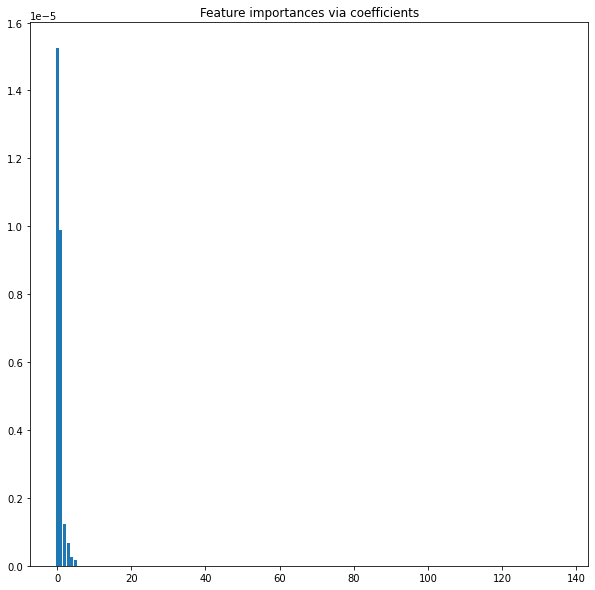

               0                                 1
28   1.52475e-05                         avg_comms
2    9.89609e-06                             likes
29    1.2404e-06       avg_views_increase_per_hour
20   6.66324e-07                    increase_views
25   2.53824e-07                         avg_views
1      1.723e-07                             views
10             0                           pub_day
16             0                    dislikes/likes
15             0             time_to_trend_in_days
14             0                          tren_day
13             0                        tren_month
12             0              tren_day_of_the_week
11             0                          pub_hour
7              0            video_error_or_removed
9              0                         pub_month
8              0               pub_day_of_the_week
18             0                    dislikes/views
6              0                  ratings_disabled
5              0               

In [16]:
r2 = getFILasso(X,y)

## Selecting features based on  LinearSVC and sklearn SelectFromModel

In [17]:
r4 = selectFromModelSVC(X,y)

Before: (6283, 137)
After: (6283, 96)
Index(['channel_title', 'likes', 'dislikes', 'comment_count',
       'pub_day_of_the_week', 'pub_month', 'pub_day', 'pub_hour',
       'tren_day_of_the_week', 'tren_month', 'tren_day',
       'time_to_trend_in_days', 'dislikes/likes', 'increase_likes',
       'increase_dislikes', 'increase_comms', 'times_in_trend', 'avg_likes',
       'avg_dislikes', 'avg_comms', 'n_of_tags', 'title_length',
       'title_n_of_words', 'title_capital_letters', 'title_small_letters',
       'title_punctuation', 'desc_length', 'desc_n_of_words',
       'desc_capital_letters', 'desc_small_letters', 'desc_punctuation',
       'desc_n_of_urls', 'desc_n_of_emojis', 'isFacebook', 'isTwitter',
       'isInstagram', 'mean_r', 'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b',
       'entropy', 'avg_texts_coordX', 'avg_texts_coordY', 'Sad', 'Fear',
       'Angry', 'Happy', 'Neutral', 'people', 'faces', 'mean_h', 'mean_s',
       'std_s', 'TFIDF_title_clean_24', 'TFIDF_title_clean

# US data feature importance

In [18]:
X, y = prepeareData(dfGb)
print(dfGb.shape)
dfGb

(3235, 138)


,channel_title,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,pub_day_of_the_week,pub_month,pub_day,pub_hour,tren_day_of_the_week,tren_month,tren_day,time_to_trend_in_days,dislikes/likes,likes/views,dislikes/views,comment_count/views,increase_views,increase_likes,increase_dislikes,increase_comms,times_in_trend,avg_views,avg_likes,avg_dislikes,avg_comms,avg_views_increase_per_hour,n_of_tags,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram,mean_r,mean_g,mean_b,std_r,std_g,std_b,entropy,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,Sad,Fear,Angry,Happy,Neutral,Surprise,people,faces,mean_h,mean_s,mean_v,std_h,std_s,std_v,TFIDF_title_clean_22,TFIDF_title_clean_24,TFIDF_title_clean_17,TFIDF_title_clean_10,TFIDF_title_clean_20,TFIDF_title_clean_26,TFIDF_title_clean_1,TFIDF_title_clean_25,TFIDF_title_clean_23,TFIDF_title_clean_27,TFIDF_title_clean_15,TFIDF_title_clean_28,TFIDF_title_clean_2,TFIDF_title_clean_29,TFIDF_title_clean_19,TFIDF_clean_thumb_ocr_text_V2_22,TFIDF_clean_thumb_ocr_text_V2_24,TFIDF_clean_thumb_ocr_text_V2_17,TFIDF_clean_thumb_ocr_text_V2_10,TFIDF_clean_thumb_ocr_text_V2_20,TFIDF_clean_thumb_ocr_text_V2_26,TFIDF_clean_thumb_ocr_text_V2_1,TFIDF_clean_thumb_ocr_text_V2_25,TFIDF_clean_thumb_ocr_text_V2_23,TFIDF_clean_thumb_ocr_text_V2_27,TFIDF_clean_thumb_ocr_text_V2_15,TFIDF_clean_thumb_ocr_text_V2_28,TFIDF_clean_thumb_ocr_text_V2_2,TFIDF_clean_thumb_ocr_text_V2_29,TFIDF_clean_thumb_ocr_text_V2_19,TFIDF_categories_str_22,TFIDF_categories_str_24,TFIDF_categories_str_17,TFIDF_categories_str_10,TFIDF_categories_str_20,TFIDF_categories_str_26,TFIDF_categories_str_1,TFIDF_categories_str_25,TFIDF_categories_str_23,TFIDF_categories_str_27,TFIDF_categories_str_15,TFIDF_categories_str_28,TFIDF_categories_str_2,TFIDF_categories_str_29,TFIDF_categories_str_19,TFIDF_objects_str_22,TFIDF_objects_str_24,TFIDF_objects_str_17,TFIDF_objects_str_10,TFIDF_objects_str_20,TFIDF_objects_str_26,TFIDF_objects_str_1,TFIDF_objects_str_25,TFIDF_objects_str_23,TFIDF_objects_str_27,TFIDF_objects_str_15,TFIDF_objects_str_28,TFIDF_objects_str_2,TFIDF_objects_str_29,TFIDF_objects_str_19
0,583,22.0,209192.0,11119.0,153.0,740.0,0,0,0,4.0,12.0,29.0,15.0,6.0,12.0,31.0,2.367083,0.013760,0.053152,0.000731,0.003537,68556.0,1441.0,85.0,58.0,14.0,3.518632e+05,14660.642857,279.857143,822.357143,8.837543e+04,13.0,48.0,8.0,39.0,0.812500,0.0,0.000000,2.0,0.041667,0.0,4233.0,343.0,550.0,0.129931,2591.0,0.612095,181.0,0.131349,49.0,0.0,0,1,1,117.494479,92.533154,81.868125,78.208238,66.535987,63.170421,6.592854,-1.00,-1.0,0.00,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,0.097748,0.269502,0.461717,0.191174,0.261466,0.306843,0.054150,0.000000,0.070003,0.018103,0.044056,0.000000,0.150150,0.291142,0.119269,0.161162,0.136377,0.501941,0.034668,0.087795,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.868305,0.080773,0.907330,0.395267,0.525517,0.143640,0.561622,1.258430,0.895113,0.892952,0.826353,1.752035,0.710898,0.676330,0.824014,1.905524,1.546074,2.048430,1.300220,2.094693,1.932678,1.694909,1.992515,1.974153,2.025556,2.031608,1.727420,1.609695,1.476882,1.550752
1,1379,24.0,544638.0,7985.0,330.0,1038.0,0,0,0,1.0,2.0,13.0,17.0,2.0,2.0,14.0,1.291574,0.041327,0.014661,0.000606,0.001906,1213961.0,8203.0,502.0,1144.0,2.0,1.151618e+06,12086.500000,581.000000,1610.000000,4.216855e+05,29.0,33.0,6.0,24.0,0.727273,0.0,0.000000,3.0,0.090909,0.0,2952.0,434.0,233.0,0.078930,2104.0,0.712737,143.0,0.056572,0.0,0.0,0,0,0,93.674803,92.477541,88.659589,60.341841,57.863485,55.318110,6.028524,-1.00,-1.0,0.00,0.0,0.0,1.0,0.0,0

## Feature Importance based on Random Forest

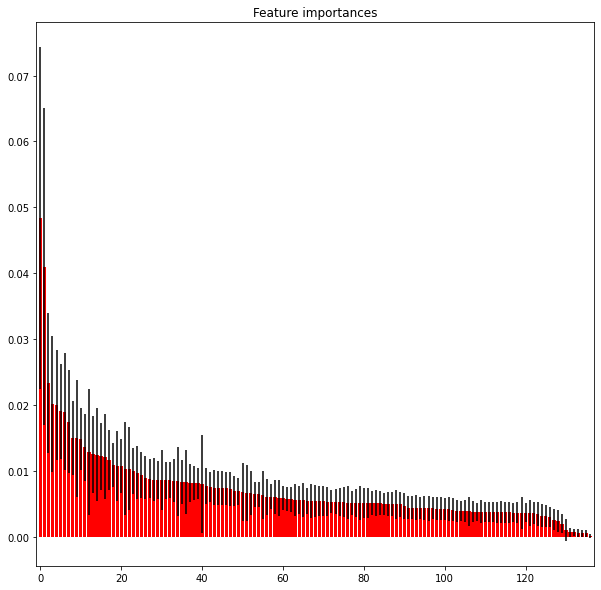

Feature ranking:
1. feature TFIDF_clean_thumb_ocr_text_V2_17 (0.048424)
2. feature TFIDF_title_clean_17 (0.041020)
3. feature TFIDF_title_clean_20 (0.023396)
4. feature TFIDF_clean_thumb_ocr_text_V2_27 (0.020213)
5. feature TFIDF_title_clean_27 (0.020083)
6. feature TFIDF_title_clean_1 (0.019082)
7. feature TFIDF_title_clean_28 (0.019040)
8. feature TFIDF_title_clean_22 (0.017528)
9. feature TFIDF_title_clean_15 (0.015037)
10. feature TFIDF_clean_thumb_ocr_text_V2_20 (0.015016)
11. feature TFIDF_title_clean_25 (0.014832)
12. feature TFIDF_title_clean_23 (0.013600)
13. feature title_punctuation_percent (0.012907)
14. feature TFIDF_clean_thumb_ocr_text_V2_1 (0.012547)
15. feature likes/views (0.012519)
16. feature TFIDF_title_clean_29 (0.012249)
17. feature TFIDF_clean_thumb_ocr_text_V2_22 (0.012181)
18. feature n_of_tags (0.011673)
19. feature channel_title (0.010938)
20. feature TFIDF_clean_thumb_ocr_text_V2_23 (0.010825)
21. feature TFIDF_clean_thumb_ocr_text_V2_25 (0.010727)
22. feat

In [19]:
g1 = getFI_RForest(X,y)

## Feature Importance based on Bagging + Decision tree

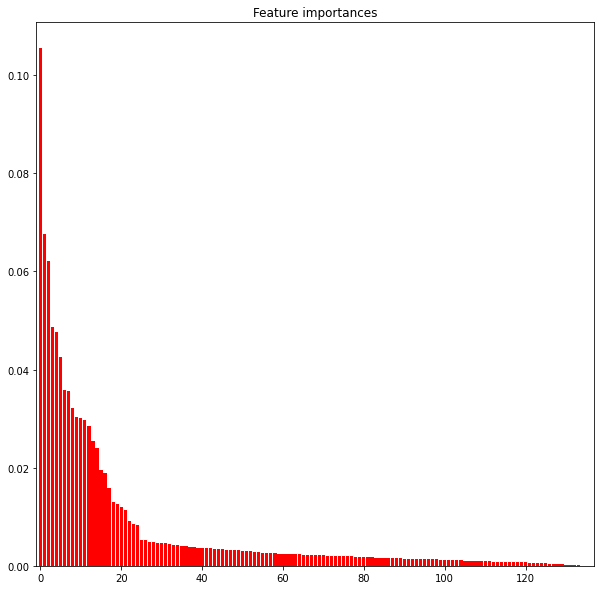

Feature ranking:
1. feature TFIDF_title_clean_17 (0.105496)
2. feature TFIDF_clean_thumb_ocr_text_V2_17 (0.067676)
3. feature TFIDF_clean_thumb_ocr_text_V2_27 (0.062042)
4. feature TFIDF_title_clean_28 (0.048621)
5. feature TFIDF_title_clean_27 (0.047694)
6. feature TFIDF_title_clean_20 (0.042464)
7. feature TFIDF_title_clean_25 (0.035828)
8. feature TFIDF_clean_thumb_ocr_text_V2_1 (0.035574)
9. feature TFIDF_title_clean_23 (0.032070)
10. feature TFIDF_clean_thumb_ocr_text_V2_20 (0.030238)
11. feature TFIDF_clean_thumb_ocr_text_V2_22 (0.030208)
12. feature TFIDF_title_clean_22 (0.029791)
13. feature TFIDF_clean_thumb_ocr_text_V2_25 (0.028407)
14. feature TFIDF_title_clean_1 (0.025480)
15. feature TFIDF_clean_thumb_ocr_text_V2_23 (0.023991)
16. feature TFIDF_title_clean_15 (0.019518)
17. feature TFIDF_clean_thumb_ocr_text_V2_15 (0.018965)
18. feature TFIDF_title_clean_10 (0.015767)
19. feature title_punctuation_percent (0.013018)
20. feature TFIDF_title_clean_29 (0.012580)
21. feature T

In [20]:
g3 = getFI_Bagging(X,y)

## Feature Importance based on LassoCV

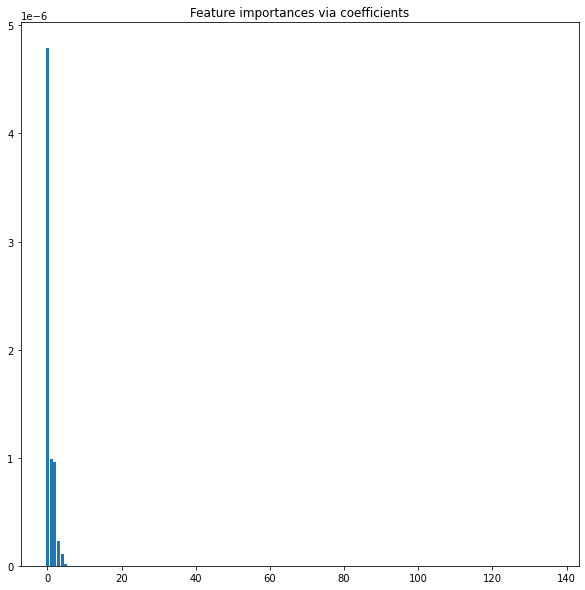

               0                                 1
2    4.78937e-06                             likes
29   9.86054e-07       avg_views_increase_per_hour
26   9.56774e-07                         avg_likes
20   2.32964e-07                    increase_views
25   1.10697e-07                         avg_views
1    1.62492e-08                             views
10             0                           pub_day
16             0                    dislikes/likes
15             0             time_to_trend_in_days
14             0                          tren_day
13             0                        tren_month
12             0              tren_day_of_the_week
11             0                          pub_hour
7              0            video_error_or_removed
9              0                         pub_month
8              0               pub_day_of_the_week
18             0                    dislikes/views
6              0                  ratings_disabled
5              0               

In [21]:
g2 = getFILasso(X,y)

## Selecting features based on  LinearSVC and sklearn SelectFromModel

In [22]:
g4 = selectFromModelSVC(X,y)

Before: (3235, 137)
After: (3235, 76)
Index(['channel_title', 'likes', 'dislikes', 'comment_count',
       'pub_day_of_the_week', 'pub_month', 'pub_day', 'pub_hour',
       'tren_day_of_the_week', 'tren_month', 'tren_day',
       'time_to_trend_in_days', 'dislikes/likes', 'increase_likes',
       'increase_dislikes', 'increase_comms', 'times_in_trend', 'avg_likes',
       'avg_dislikes', 'avg_comms', 'n_of_tags', 'title_length',
       'title_n_of_words', 'title_capital_letters', 'title_small_letters',
       'title_punctuation', 'desc_length', 'desc_n_of_words',
       'desc_capital_letters', 'desc_small_letters', 'desc_punctuation',
       'desc_n_of_urls', 'desc_n_of_emojis', 'isFacebook', 'isTwitter',
       'isInstagram', 'mean_r', 'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b',
       'entropy', 'avg_texts_coordX', 'avg_texts_coordY',
       'ocr_sentiment_compound', 'Sad', 'Angry', 'Happy', 'Neutral', 'people',
       'faces', 'TFIDF_title_clean_22', 'TFIDF_title_clean_17',
     

In [47]:
N = 50

uslist1 = list(r1[1][:N])
uslist2 = list(r2[1][:N])
uslist3 = list(r3[1][:N])
uslist4 = r4

In [48]:
gblist1 = list(g1[1][:N])
gblist2 = list(g2[1][:N])
gblist3 = list(g3[1][:N])
gblist4 = g4

In [49]:
set(uslist1).intersection(set(uslist3)).intersection(set(uslist4))

{'TFIDF_clean_thumb_ocr_text_V2_15',
 'TFIDF_clean_thumb_ocr_text_V2_2',
 'TFIDF_clean_thumb_ocr_text_V2_20',
 'TFIDF_clean_thumb_ocr_text_V2_22',
 'TFIDF_clean_thumb_ocr_text_V2_24',
 'TFIDF_clean_thumb_ocr_text_V2_26',
 'TFIDF_clean_thumb_ocr_text_V2_28',
 'TFIDF_title_clean_1',
 'TFIDF_title_clean_10',
 'TFIDF_title_clean_15',
 'TFIDF_title_clean_17',
 'TFIDF_title_clean_2',
 'TFIDF_title_clean_22',
 'TFIDF_title_clean_24',
 'TFIDF_title_clean_26',
 'TFIDF_title_clean_27',
 'TFIDF_title_clean_28',
 'TFIDF_title_clean_29',
 'channel_title',
 'desc_capital_letters',
 'desc_n_of_words',
 'desc_punctuation',
 'mean_r',
 'n_of_tags',
 'title_capital_letters',
 'title_length',
 'title_small_letters'}

In [50]:
set(gblist1).intersection(set(gblist3)).intersection(set(gblist4))

{'TFIDF_clean_thumb_ocr_text_V2_17',
 'TFIDF_clean_thumb_ocr_text_V2_23',
 'TFIDF_clean_thumb_ocr_text_V2_27',
 'TFIDF_title_clean_1',
 'TFIDF_title_clean_15',
 'TFIDF_title_clean_17',
 'TFIDF_title_clean_20',
 'TFIDF_title_clean_22',
 'TFIDF_title_clean_23',
 'TFIDF_title_clean_25',
 'TFIDF_title_clean_27',
 'TFIDF_title_clean_28',
 'channel_title',
 'desc_capital_letters',
 'desc_n_of_urls',
 'desc_n_of_words',
 'desc_punctuation',
 'desc_small_letters',
 'n_of_tags',
 'pub_hour',
 'title_capital_letters',
 'title_length',
 'title_small_letters'}